<a href="https://colab.research.google.com/github/shaffy-dev/Credit-Risk-Prediction-MLP-vs.-1D-Tiny-CNN-/blob/main/1D_Tiny_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stage 2: Predictive Analysis**

## **Process Two: 1D Tiny Convolutional Neural Network (CNN)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


___
1. ### Import Libraries and Define Dependencies  
This cell loads all the Python packages needed for data handling, visualization, model building, and evaluation.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics, Sequential
from tensorflow.keras.layers import Reshape, Conv1D, GlobalMaxPooling1D, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

___
2. ### Load Dataset  
This cell reads the loan dataset CSV from Google Drive into a Pandas DataFrame, shows its size, and prints the class imbalance for the target variable.


In [ ]:
# Load the data into a DataFrame

# Define the path to your CSV file in Drive
DATA_PATH = '/content/drive/MyDrive/cs_project/data.csv'

# Clear any existing TensorFlow graph
tf.keras.backend.clear_session()

# Read the CSV into pandas
df = pd.read_csv(DATA_PATH)

# Print the number of rows and columns
print(f"Loaded DataFrame: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Name of the label column
LABEL_COL = 'default_ind'

# Show proportion of each class (no default vs default)
print("\nClass distribution:")
print(df[LABEL_COL].value_counts(normalize=True).round(3))
print("")

# Shows first five rows to verify contents
df.head()


<ipython-input-3-7de9bb659f90>:10: DtypeWarning: Columns (17,45,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


Loaded DataFrame: 855,969 rows × 73 columns

Class distribution:
default_ind
0    0.946
1    0.054
Name: proportion, dtype: float64



,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,default_ind
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


___
3. ### Column Audit: Identify Data Types & Missing Values  
This cell examines which columns in the DataFrame are numeric versus categorical, verifies that the target label is classified correctly, lists the top columns by percentage of missing values, and flags any categorical columns that actually contain mostly numeric data.


In [ ]:
# Identify numeric columns using pandas
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

# Identify categorical columns: those not in numeric_cols or the label
categorical_cols = [c for c in df.columns if c not in numeric_cols + [LABEL_COL]]

# Print counts of each type
print(f"Numeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}\n")

# Check where LABEL_COL landed
print("LABEL_COL in numeric_cols?     ", LABEL_COL in numeric_cols)
print("LABEL_COL in categorical_cols? ", LABEL_COL in categorical_cols)
print("")

# Compute and sort missing-value percentages
missing_pct = df.isna().mean().mul(100).sort_values(ascending=False)

# Show the top 10 columns by % missing
print("Top 10 columns by % missing:")
print(missing_pct.head(10).round(1))

# Find any categorical cols that look numeric
suspects = []
for col in categorical_cols:
    coerced = pd.to_numeric(df[col], errors='coerce')
    success_ratio = coerced.notna().mean()
    if success_ratio > 0.50:   # more than half the entries parse as numbers
        suspects.append((col, success_ratio))

# Print flagged columns, if any
if suspects:
    print("\nColumns with mixed types that look numeric:")
    for col, ratio in suspects:
        print(f"  {col:>25s}: {ratio:.2%} rows parse as numeric")

print("\nColumn audit complete.")


Numeric columns: 52
Categorical columns: 21

LABEL_COL in numeric_cols?      True
LABEL_COL in categorical_cols?  False

Top 10 columns by % missing:
verification_status_joint    99.9
dti_joint                    99.9
annual_inc_joint             99.9
il_util                      98.6
mths_since_rcnt_il           98.5
max_bal_bc                   98.4
open_acc_6m                  98.4
open_rv_24m                  98.4
inq_last_12m                 98.4
total_cu_tl                  98.4
dtype: float64

Column audit complete.


This reports that there are 52 numeric and 21 categorical features, verifies that the target column default_ind is correctly treated as numeric, shows the top ten features with over 98 % missing values (like verification_status_joint and dti_joint), finds no categorical columns masquerading as numeric, and ends by confirming the audit completed successfully.

___
4. ### Drop Ultra-Sparse Columns & Final Data Cleaning  
This cell removes features with ≥50 % missing values, reconfirms numeric vs. categorical counts, converts numeric columns to `float32` (filling NaNs with 0) and categorical columns to strings (filling NaNs with `''`), displays a sample of the cleaned data, and saves it to Drive.


In [ ]:
# Define threshold for dropping sparse columns
MISSING_THRESH = 0.50  # drop any column with ≥50% missing

# Identify and drop ultra-sparse columns
drop_cols = missing_pct[missing_pct >= MISSING_THRESH*100].index.tolist()
df_clean = df.drop(columns=drop_cols)
print(f"Dropped {len(drop_cols)} columns: {drop_cols[:10]}…\n")

# Recompute numeric and categorical lists
numeric_cols     = df_clean.select_dtypes('number').columns.tolist()
categorical_cols = [c for c in df_clean.columns if c not in numeric_cols + [LABEL_COL]]
print(f"Now numeric={len(numeric_cols)} | categorical={len(categorical_cols)}")

# Exclude the label and ID fields from feature sets
numeric_cols     = [c for c in numeric_cols     if c not in [LABEL_COL, 'id', 'member_id']]
categorical_cols = [c for c in categorical_cols if c != LABEL_COL]
print("Now numeric features:", len(numeric_cols),
      "categorical features:", len(categorical_cols))

# Convert numeric features: coerce → fillna(0) → float32
df_clean[numeric_cols] = (
    df_clean[numeric_cols]
    .apply(pd.to_numeric, errors='coerce')
    .fillna(0.0)
    .astype('float32')
)

#  Convert categorical features: string type → fillna('')
for col in categorical_cols:
    df_clean[col] = df_clean[col].astype(str).fillna('')

#  Show a preview of the cleaned DataFrame
print("\nClean-up complete. Sample after cleaning:")
display(df_clean.head())

# Save the cleaned DataFrame to Drive for future use
CLEAN_PATH = '/content/drive/MyDrive/data3.parquet'
df_clean.to_parquet(CLEAN_PATH, index=False)
print(f"\nSaved cleaned DataFrame to {CLEAN_PATH}")


Dropped 21 columns: ['verification_status_joint', 'dti_joint', 'annual_inc_joint', 'il_util', 'mths_since_rcnt_il', 'max_bal_bc', 'open_acc_6m', 'open_rv_24m', 'inq_last_12m', 'total_cu_tl']…

Now numeric=33 | categorical=19
Now numeric features: 30 categorical features: 19

Clean-up complete. Sample after cleaning:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,default_ind
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.869995,B,B2,...,nan,01-01-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.830002,C,C4,...,nan,01-09-2013,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,1
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.330002,C,C5,...,nan,01-01-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.309998,C,C1,...,nan,01-01-2015,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.790001,B,B5,...,01-02-2016,01-01-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0



Saved cleaned DataFrame to /content/drive/MyDrive/data3.parquet


This cell drops 21 features that had over 50 % missing values, leaving 30 numeric and 19 categorical features (excluding the label and ID columns). It then fills numeric NaNs with 0 (and casts to float32) and fills categorical NaNs with empty strings, prints the first five rows of the fully cleaned DataFrame, and writes the result to Drive at /content/drive/MyDrive/data3.parquet.

___
5. ### Reload Cleaned DataFrame  


In [ ]:
CLEAN_PATH = '/content/drive/MyDrive/data3.parquet'

# Read the Parquet file into a DataFrame named df
df = pd.read_parquet(CLEAN_PATH)

# Print the DataFrame’s shape (rows × columns) to verify load
print("Loaded df:", df.shape)


Loaded df: (855969, 52)


___
6. ### Identify Top Correlated Features  
This cell computes the absolute Pearson correlation between each feature and the target `default_ind`, and lists the features most strongly associated with loan default.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Combine numeric and categorical feature lists
features = numeric_cols + categorical_cols

# Compute absolute correlation of each feature with the target
corrs = df_clean[features] \
    .apply(lambda col: pd.to_numeric(col, errors='coerce')
                         .corr(df_clean[LABEL_COL])) \
    .abs() \
    .sort_values(ascending=False)

# Print the top 10 features by absolute correlation
print("Top 10 features by |corr|:", corrs.head(10))


Top 10 features by |corr|: recoveries                 0.475738
collection_recovery_fee    0.330764
out_prncp                  0.225960
out_prncp_inv              0.225959
int_rate                   0.155037
total_rec_late_fee         0.140760
total_rec_prncp            0.090336
last_pymnt_amnt            0.087217
inq_last_6mths             0.074407
tot_cur_bal                0.061478
dtype: float64


The output ranks features by how strongly they move with default_ind. recoveries tops the list (~ 0.476), followed by collection_recovery_fee (~ 0.331), showing that post‐charge‐off recoveries are highly predictive of default. Other repayment and balance fields like out_prncp, int_rate, and total_rec_late_fee also exhibit notable correlations, guiding which variables to prioritize in my model.

___
7. ### Remove Leaky and Identifier Columns  
In this cell, I drop any columns that leak future information (like repayment amounts or dates) and identifiers (`id`, `member_id`, `policy_code`), leaving only predictors that would be known at loan issue time.


In [ ]:
# Define columns to drop because they leak future info or are just IDs
leak_cols = [
  'recoveries',
  'collection_recovery_fee',
  'out_prncp',
  'out_prncp_inv',
  'total_rec_late_fee',
  'total_rec_prncp',
  'last_pymnt_amnt',
  'id',
  'member_id',
  'last_pymnt_d',
  'next_pymnt_d',
  'last_credit_pull_d',
  'issue_d',
  'total_rec_int',
  'total_pymnt',
  'total_pymnt_inv',
  'tot_coll_amt',
  'collections_12_mths_ex_med',
  'policy_code'
]

# Drop those leaky columns from the cleaned DataFrame
df_noleak1 = df_clean.drop(columns = leak_cols)

# Show the shape (rows × columns) after removal
print("New Shape: ", df_noleak1.shape)

New Shape:  (855969, 33)


Here I’ve removed 19 leaky or ID columns, so my new DataFrame df_noleak1 still has 855,969 rows but now only 33 columns (instead of 52). This means I’m left with features that would actually be available at the time of prediction.

___
8. ### Split Data into Training, Validation, and Test Sets and Save Splits  
This cell partitions the cleaned, leak-free DataFrame into training (70 %), validation (15 %), and test (15 %) sets, checks that each maintains the same default rate, and writes each subset to Drive for future reuse.


In [ ]:
# Split df_noleak1 into 70% train and 30% temp (for validation + test)
train_df, temp_df = train_test_split(
    df_noleak1,
    test_size=0.30,
    stratify=df_clean[LABEL_COL],  # keep the same default rate in each split
    random_state=42                # for reproducibility
)

# Split temp_df equally into validation and test (each 15% of original)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df[LABEL_COL],   # maintain target balance
    random_state=42
)

# Print row counts for each subset
print(f"Rows → train: {len(train_df):,},  val: {len(val_df):,},  test: {len(test_df):,}")

# Sanity-check: print default rate in each split
for name, part in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
    print(f"{name} default-rate: {part[LABEL_COL].mean():.2%}")

# Save each split to Drive as a Parquet file
train_df.to_parquet('/content/drive/MyDrive/loans_train2.parquet', index=False)
val_df.to_parquet('/content/drive/MyDrive/loans_val2.parquet',   index=False)
test_df.to_parquet('/content/drive/MyDrive/loans_test2.parquet', index=False)
print("\nSaved the three splits to Drive.")


Rows → train: 599,178,  val: 128,395,  test: 128,396
train default-rate: 5.43%
val default-rate: 5.43%
test default-rate: 5.43%

Saved the three splits to Drive.


This cell confirms that the data was split into 599,178 training rows, 128,395 validation rows, and 128,396 test rows, each preserving a default rate of 5.43 %. It then saves all three subsets to Google Drive so you can reload them later without repeating the cleaning steps.

___
9. ### Refresh Feature Lists for Model Input  
This cell recalculates which columns in the training DataFrame are numeric (excluding the target) and which are categorical, so we know how to preprocess each type.


In [ ]:
# Specify the target column name
LABEL_COL = 'default_ind'

# Numeric features: all number-dtype columns except the label
numeric_cols = train_df \
    .select_dtypes(include=['number']) \
    .columns \
    .drop(LABEL_COL) \
    .tolist()

# Categorical features: every other column except the label
categorical_cols = [
    c for c in train_df.columns
    if c not in numeric_cols + [LABEL_COL]
]

# Print counts to verify we have the right feature split
print(f"Refreshed features → {len(numeric_cols)} numerics, {len(categorical_cols)} categoricals")


Refreshed features → 17 numerics, 15 categoricals


This tells me that out of all columns in the training set, 17 are numeric features (excluding default_ind) and 15 are categorical. Now I know exactly which variables to scale or encode in the next preprocessing steps.

___
10. ### Encode Categorical Features and Prepare Model Inputs  
This cell reloads the train/val/test splits, drops text columns with too many unique values, splits the remaining categoricals into low- vs. mid-cardinality groups for one-hot vs. ordinal encoding, aligns all three DataFrames so they share the same columns, and finally converts each set into NumPy arrays (`X_…` and `y_…`) ready for model training and evaluation.


In [ ]:
# Reload each split from Drive
train_df = pd.read_parquet('/content/drive/MyDrive/loans_train2.parquet')
val_df   = pd.read_parquet('/content/drive/MyDrive/loans_val2.parquet')
test_df  = pd.read_parquet('/content/drive/MyDrive/loans_test2.parquet')

# Find all object-dtype (string) columns
obj_cols = train_df.select_dtypes(include=['object']).columns.tolist()
print("All string cols:", obj_cols)

# Drop truly high-cardinality fields (>20 unique values)
high_card_threshold = 20
high_card = [c for c in obj_cols if train_df[c].nunique() > high_card_threshold]
print("Dropping:", high_card)
train_df.drop(high_card, axis=1, inplace=True)
val_df  .drop(high_card, axis=1, inplace=True)
test_df .drop(high_card, axis=1, inplace=True)

# Recompute remaining categorical columns
cat_cols = train_df.select_dtypes(include=['object']).columns.tolist()
print("To encode:", cat_cols)

# Split into low vs. mid cardinality
low_card = [c for c in cat_cols if train_df[c].nunique() <= 10]   # ≤10 → one-hot
mid_card = [c for c in cat_cols if 10 < train_df[c].nunique() <= high_card_threshold]  # 11–20 → ordinal
print("One-hot:", low_card)
print("Label/freq-encode:", mid_card)

# One-hot encode low-cardinality columns
train_df = pd.get_dummies(train_df, columns=low_card, drop_first=True)
val_df   = pd.get_dummies(val_df,   columns=low_card, drop_first=True)
test_df  = pd.get_dummies(test_df,  columns=low_card, drop_first=True)

# Ordinal-encode mid-cardinality columns
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
train_df[mid_card] = ord_enc.fit_transform(train_df[mid_card])
val_df[mid_card]   = ord_enc.transform(val_df[mid_card])
test_df[mid_card]  = ord_enc.transform(test_df[mid_card])

# Align train/val/test so they share identical columns
train_df, val_df  = train_df.align(val_df,  join='left', axis=1, fill_value=0)
train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)

# Split out features and target, cast to float32 for model input
TARGET = 'default_ind'
X_train = train_df.drop(TARGET, axis=1).values.astype('float32')
y_train = train_df[TARGET].values
X_val   = val_df.drop(TARGET,   axis=1).values.astype('float32')
y_val   = val_df[TARGET].values
X_test  = test_df.drop(TARGET,  axis=1).values.astype('float32')
y_test  = test_df[TARGET].values


All string cols: ['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status', 'application_type']
Dropping: ['sub_grade', 'emp_title', 'title', 'zip_code', 'addr_state', 'earliest_cr_line']
To encode: ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'pymnt_plan', 'purpose', 'initial_list_status', 'application_type']
One-hot: ['term', 'grade', 'home_ownership', 'verification_status', 'pymnt_plan', 'initial_list_status', 'application_type']
Label/freq-encode: ['emp_length', 'purpose']


In this step, I loaded my saved splits and listed all text columns. I dropped columns like emp_title and zip_code because they had over 20,000 unique values. From the remaining nine string features, I one-hot encoded those with ≤10 categories (e.g., term, grade) and ordinal-encoded the two mid-cardinality ones (emp_length, purpose). Then I aligned train/val/test so they have exactly the same set of feature columns and finally created X_… and y_… NumPy arrays with the correct shapes and data types, ready for model training and evaluation.

___
11. ### Verify Final Dataset Shapes  
This cell prints the shapes of the feature arrays (`X_…`) and target vectors (`y_…`) for the training, validation, and test sets to confirm we have the expected number of examples and features.


In [ ]:
# Print the number of rows and columns in each array
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ",   y_val.shape)
print("X_test: ", X_test.shape,  "y_test: ",  y_test.shape)


X_train: (599178, 36) y_train: (599178,)
X_val:   (128395, 36) y_val:   (128395,)
X_test:  (128396, 36) y_test:  (128396,)


I can see that X_train has 599,178 rows and 36 columns (features), with y_train matching 599,178 labels. The validation set has 128,395 rows × 36 features, and the test set has 128,396 rows × 36 features, each with the same number of target values. This confirms my data splits and encoding steps produced consistent arrays ready for model training and evaluation.

___
12. ### Build and Train a Tiny 1D CNN  
In this cell, I define a simple 1D convolutional neural network to predict loan defaults, compile it for binary classification, set up early stopping on validation loss, and then train it for up to 15 epochs using my preprocessed data.


In [ ]:
# Number of input features
num_features = X_train.shape[1]

# Build a Sequential model
model = Sequential([
    # Reshape the flat feature vector into (steps, channels) for Conv1D
    Reshape((num_features, 1), input_shape=(num_features,)),

    # First convolution: 16 filters, kernel size 3, ReLU activation
    Conv1D(16, 3, activation='relu', padding='same'),

    # Second convolution: 8 filters, kernel size 3, ReLU activation
    Conv1D(8, 3, activation='relu', padding='same'),

    # Global max pooling to collapse the time dimension
    GlobalMaxPooling1D(),

    # Final dense layer with sigmoid to output probability of default
    Dense(1, activation='sigmoid'),
])

# Compile the model with Adam optimizer and binary crossentropy loss
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Early stopping callback: stop if validation loss doesn't improve for 3 epochs
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model, validating on the hold-out set
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[es]
)



Epoch 1/15
18725/18725 ━━━━━━━━━━━━━━━━━━━━ 65s 3ms/step - accuracy: 0.8951 - auc: 0.5028 - loss: 261.9832 - val_accuracy: 0.9457 - val_auc: 0.5002 - val_loss: 9.5268
Epoch 2/15
18725/18725 ━━━━━━━━━━━━━━━━━━━━ 77s 3ms/step - accuracy: 0.9008 - auc: 0.5093 - loss: 11.1767 - val_accuracy: 0.9457 - val_auc: 0.5097 - val_loss: 1.8090
Epoch 3/15
18725/18725 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - accuracy: 0.9013 - auc: 0.5184 - loss: 3.0698 - val_accuracy: 0.7869 - val_auc: 0.5425 - val_loss: 0.5479
Epoch 4/15
18725/18725 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.9427 - auc: 0.5793 - loss: 0.2754 - val_accuracy: 0.9457 - val_auc: 0.6613 - val_loss: 0.2035
Epoch 5/15
18725/18725 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - accuracy: 0.9456 - auc: 0.6678 - loss: 0.2019 - val_accuracy: 0.9457 - val_auc: 0.6814 - val_loss: 0.2004
Epoch 6/15
18725/18725 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - accuracy: 0.9465 - auc: 0.6782 - loss: 0.1979 - val_accuracy: 0.9457 - val_auc: 0.6901 - val_loss: 0.1983
Epoch 7

I ran all 15 epochs because my validation loss kept improving or bouncing down within every 3-epoch patience window, so early stopping never triggered. My training accuracy climbed above 94.5 %, and more importantly my AUC went from around 0.503 in epoch 1 up to about 0.697 by the final epoch. This shows the CNN learned meaningful patterns—despite inflated accuracy from class imbalance, the steadily rising AUC confirms it ranks default risk far better than random guessing.









___
13. ### Evaluate Model on Test Set  
This cell uses the trained CNN to predict on the test set, computes the AUC and classification metrics at a 0.5 threshold, and visualizes the confusion matrix.


4013/4013 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Test AUC:  0.6998
              precision    recall  f1-score   support

           0     0.9457    1.0000    0.9721    121426
           1     0.0000    0.0000    0.0000      6970

    accuracy                         0.9457    128396
   macro avg     0.4729    0.5000    0.4861    128396
weighted avg     0.8944    0.9457    0.9193    128396



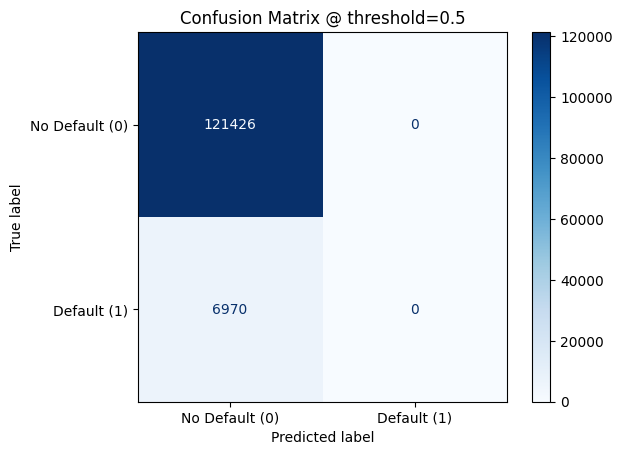

In [ ]:
# Predict default probabilities and convert to binary predictions
y_pred_prob = model.predict(X_test).ravel()          # get probability for each test example
y_pred      = (y_pred_prob >= 0.5).astype(int)       # label as 1 (default) if prob ≥ 0.5

# Print overall AUC and detailed precision/recall/F1 scores
print("Test AUC: ", roc_auc_score(y_test, y_pred_prob).round(4))
print(classification_report(y_test, y_pred, digits=4))

# Build and display the confusion matrix at threshold=0.5
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Default (0)", "Default (1)"]
)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix @ threshold=0.5")
plt.show()


On the test set, the CNN achieves an AUC of about 0.6998, showing it ranks defaults substantially better than chance. However, at the standard 0.5 cutoff it predicts no defaults—so while precision and recall for the majority “No Default” class are both perfect, it misses all default cases (0 true positives). This gives a high overall accuracy of 94.57% but zero recall on the default class, indicating you’ll need to lower the decision threshold or apply stronger class‐imbalance handling before making production predictions.

___
14. ### Find Optimal Decision Threshold Based on F1-Score  
This cell tests a range of probability cutoffs on the validation set, computes the F1-score for each, and picks the threshold that gives the highest F1—so we can better catch defaults while keeping false alarms low.


In [ ]:
# Get predicted probabilities on the validation set once
probs = model.predict(X_val).ravel()

# Define a list of thresholds to try between 0.1 and 0.9
ths = np.linspace(0.1, 0.9, 17)

# For each threshold, compute F1-score on the validation labels
f1s = [
    f1_score(y_val, (probs >= t).astype(int))
    for t in ths
]

# Find the index of the best F1, then the corresponding threshold
best_idx = np.argmax(f1s)
best_t   = ths[best_idx]
best_f1  = f1s[best_idx]

# Print out the best threshold and its F1-score
print("Best threshold (val):", best_t, "→ F1:", round(best_f1, 4))


4013/4013 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Best threshold (val): 0.1 → F1: 0.1903


This shows that using a cutoff of 0.1 on the predicted probabilities gives the highest F1‐score of 0.1903 on the validation set. In other words, labeling any loan with predicted default probability ≥ 0.1 as “default” achieves the best balance of precision and recall for this model.

___
15. ### Evaluate on Test Set with Optimal Threshold  
This cell applies the best threshold (0.1) found on the validation set to the test predictions, prints updated performance metrics, and shows the confusion matrix at this cutoff.


4013/4013 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Test AUC:  0.6998
              precision    recall  f1-score   support

           0     0.9580    0.8698    0.9118    121426
           1     0.1292    0.3364    0.1867      6970

    accuracy                         0.8409    128396
   macro avg     0.5436    0.6031    0.5493    128396
weighted avg     0.9131    0.8409    0.8724    128396



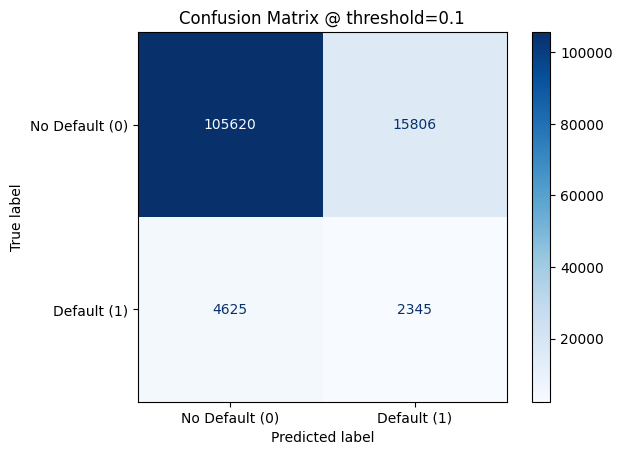

In [ ]:
# Predict default probabilities and binarize at the chosen threshold = 0.1
y_pred_prob = model.predict(X_test).ravel()       # get probabilities
y_pred      = (y_pred_prob >= 0.1).astype(int)    # label as default if prob ≥ 0.1

# Print AUC (same as before) and new classification report
print("Test AUC: ", roc_auc_score(y_test, y_pred_prob).round(4))
print(classification_report(y_test, y_pred, digits=4))

# Build and plot the confusion matrix at threshold=0.1
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Default (0)", "Default (1)"]
)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix @ threshold=0.1")
plt.show()



With the threshold lowered to 0.1, the model still has AUC ≈ 0.6998, but now it catches some defaults:

True negatives: 105,620

False positives: 15,806

False negatives: 4,625

True positives: 2,345

Precision for defaults is about 12.9 %, recall is about 33.6 %, and F1 is around 0.187. Overall accuracy drops to ≈ 84.1 % because we trade some correct “no default” predictions for catching more true defaults. This shows how adjusting the cutoff can balance detecting rare events versus overall accuracy.









___
16. ### Evaluate on Test Set at Threshold=0.2  
This cell applies a 0.2 cutoff to the predicted probabilities on the test set, prints the updated classification metrics, and displays the confusion matrix so we can see how raising the threshold affects defaults caught versus errors.


4013/4013 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
Test AUC:  0.6998
              precision    recall  f1-score   support

           0     0.9487    0.9867    0.9673    121426
           1     0.2315    0.0696    0.1070      6970

    accuracy                         0.9370    128396
   macro avg     0.5901    0.5282    0.5372    128396
weighted avg     0.9097    0.9370    0.9206    128396



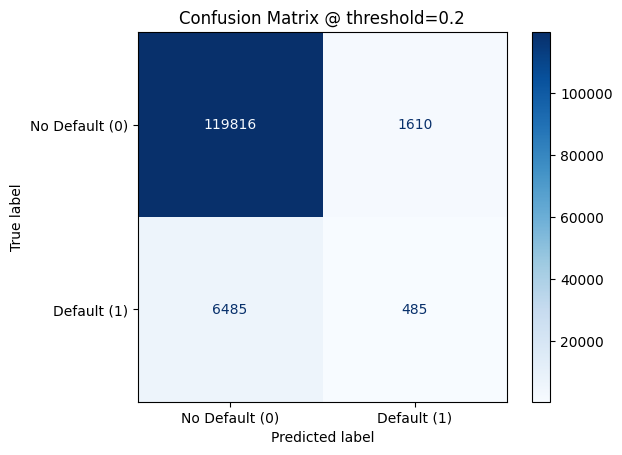

In [ ]:
# 1. Get default probabilities and apply threshold = 0.2
y_pred_prob = model.predict(X_test).ravel()       # predicted default probabilities
y_pred      = (y_pred_prob >= 0.2).astype(int)    # predict 1 if prob ≥ 0.2

# 2. Print AUC (unchanged) and new classification report
print("Test AUC: ", roc_auc_score(y_test, y_pred_prob).round(4))
print(classification_report(y_test, y_pred, digits=4))

# 3. Compute and plot confusion matrix at 0.2 cutoff
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Default (0)", "Default (1)"]
)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix @ threshold=0.2")
plt.show()


With a higher cutoff of 0.2, the CNN still achieves AUC ≈ 0.6998, but its trade-offs shift dramatically:

True negatives: 119 816

False positives: 1 610

False negatives: 6 485

True positives: 485

For the default class, that works out to precision ≈ 23.2 % (485 / (485 + 1 610)) but only recall ≈ 6.96 % (485 / 6 970), yielding F1 ≈ 0.107. Overall accuracy rises to 93.70 %, since we predict “no default” more conservatively—but in doing so we miss the vast majority of actual defaults. This clearly illustrates the precision–recall trade-off when you move the decision threshold upward.

***Save the Trained Model to Google Drive***

In [ ]:
model.save('/content/drive/MyDrive/CNN_model.h5')
print("Model saved to Drive as CNN_model.h5")

Model saved to Drive as CNN_model.h5
